#**Data Science Engineering Methods and Tools**

## **Assignment 2** – Auto ML

**Name** - Rituja Lolam

**Nuid** - 002146428

# **Abstract**



**Columns:**

age: age of primary beneficiary

sex: insurance contractor gender: female(0), male(1)

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance 

smoker: Smoker(1),Non-smoker(0)

region: the beneficiary's residential area in the US: southwest(1)
southeast(2),northwest(3),northeast(4)

charges: Individual medical costs billed by health insurance
       
     


## **Installing H2O** 

In [1]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future


!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [2]:
# Import libraries
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6 
run_time=222

In [4]:
# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

6


## **Starting H2O server** 

In [5]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:21649 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpu973x0qe
  JVM stdout: /tmp/tmpu973x0qe/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpu973x0qe/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:21649
Connecting to H2O server at http://127.0.0.1:21649 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_unknownUser_aqv0uy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## **Importing dataset** 

In [6]:
# Import the dataset from Github
url = "https://github.com/Ritujauni/Data-Science/raw/main/insurance.csv"
df = h2o.import_file(path = url)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
df.head()

age,sex,bmi,children,smoker,region,charges
19,0,27.9,0,1,1,16884.9
18,1,33.77,1,0,2,1725.55
28,1,33,3,0,2,4449.46
33,1,22.705,0,0,3,21984.5
32,1,28.88,0,0,3,3866.86
31,0,25.74,0,0,2,3756.62
46,0,33.44,1,0,2,8240.59
37,0,27.74,3,0,3,7281.51
37,1,29.83,2,0,4,6406.41
60,0,25.84,0,0,3,28923.1


In [8]:
df.types

{'age': 'int',
 'bmi': 'real',
 'charges': 'real',
 'children': 'int',
 'region': 'int',
 'sex': 'int',
 'smoker': 'int'}

In [9]:
df.describe()

Rows:1338
Cols:7




,age,sex,bmi,children,smoker,region,charges
type,int,int,real,int,int,int,real
mins,18.0,0.0,15.96,0.0,0.0,1.0,1121.8739
mean,39.20702541106125,0.5052316890881914,30.663396860986524,1.0949177877429015,0.20478325859491778,2.4843049327354265,13270.422265141255
maxs,64.0,1.0,53.13,5.0,1.0,4.0,63770.42801
sigma,14.049960379216147,0.500159569284377,6.098186911679012,1.205492739781914,0.4036940375456173,1.10488491858269,12110.011236693992
zeros,0,662,0,574,1064,0,0
missing,0,0,0,0,0,0,0
0,19.0,0.0,27.9,0.0,1.0,1.0,16884.924
1,18.0,1.0,33.77,1.0,0.0,2.0,1725.5523
2,28.0,1.0,33.0,3.0,0.0,2.0,4449.462


In [10]:
df.shape

(1338, 7)

## **Creating Train/Test split** 

In [11]:
# Create a 80/20 train/test split
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])

In [12]:
print(df_train.shape)
print(df_test.shape)

(1059, 7)
(279, 7)


In [13]:
df_train.head()

age,sex,bmi,children,smoker,region,charges
19,0,27.9,0,1,1,16884.9
18,1,33.77,1,0,2,1725.55
33,1,22.705,0,0,3,21984.5
46,0,33.44,1,0,2,8240.59
37,0,27.74,3,0,3,7281.51
37,1,29.83,2,0,4,6406.41
25,1,26.22,0,0,4,2721.32
62,0,26.29,0,1,2,27808.7
23,1,34.4,0,0,1,1826.84
56,0,39.82,0,0,2,11090.7


## **Setting target and predictor variables** 

In [14]:
# Set the features and target
X=df.columns
print(X)

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


In [15]:
y ='charges'
X.remove(y) 
print(X)

['age', 'sex', 'bmi', 'children', 'smoker', 'region']


## **Setting up AutoML** 

In [16]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1,exclude_algos = ["StackedEnsemble"])

In [17]:
aml.train(x=X,y=y,training_frame=df_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_1_20220214_44557_model_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,42.0,42.0,10568.0,4.0,4.0,4.0,12.0,16.0,15.428572




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 15613674.422518289
RMSE: 3951.4142306923845
MAE: 2148.1030087853737
RMSLE: 0.3739022071136965
Mean Residual Deviance: 15613674.422518289

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 20399225.16247999
RMSE: 4516.550139484781
MAE: 2519.145459134002
RMSLE: 0.4313969230688984
Mean Residual Deviance: 20399225.16247999

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,2.515401e+03,2.197493e+02,2.468951e+03,2.240193e+03,2.428949e+03,2.608751e+03,2.830161e+03
1,mean_residual_deviance,2.060663e+07,6.199573e+06,1.758272e+07,1.459573e+07,1.881574e+07,2.118944e+07,3.084952e+07
2,mse,2.060663e+07,6.199573e+06,1.758272e+07,1.459573e+07,1.881574e+07,2.118944e+07,3.084952e+07
3,r2,8.613316e-01,3.565665e-02,8.797433e-01,8.796552e-01,8.755759e-01,8.739765e-01,7.977074e-01
4,residual_deviance,2.060663e+07,6.199573e+06,1.758272e+07,1.459573e+07,1.881574e+07,2.118944e+07,3.084952e+07
5,rmse,4.501751e+03,6.527505e+02,4.193175e+03,3.820436e+03,4.337711e+03,4.603199e+03,5.554235e+03
6,rmsle,4.294416e-01,3.812163e-02,4.030859e-01,3.949329e-01,4.100788e-01,4.566242e-01,4.824864e-01



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-02-14 04:47:54,2.943 sec,0.0,12186.917781,9159.401135,1.485210e+08
1,,2022-02-14 04:47:55,2.980 sec,5.0,8121.844511,6245.241412,6.596436e+07
2,,2022-02-14 04:47:55,2.993 sec,10.0,5899.804875,4450.760803,3.480770e+07
3,,2022-02-14 04:47:55,3.005 sec,15.0,4845.708614,3406.084099,2.348089e+07
4,,2022-02-14 04:47:55,3.027 sec,20.0,4361.133187,2790.687278,1.901948e+07
5,,2022-02-14 04:47:55,3.039 sec,25.0,4161.585045,2464.424965,1.731879e+07
6,,2022-02-14 04:47:55,3.051 sec,30.0,4064.731276,2300.486431,1.652204e+07
7,,2022-02-14 04:47:55,3.063 sec,35.0,4002.242349,2216.250115,1.601794e+07
8,,2022-02-14 04:47:55,3.077 sec,40.0,3962.477464,2163.506198,1.570123e+07
9,,2022-02-14 04:47:55,3.126 sec,42.0,3951.414231,2148.103009,1.561367e+07



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,smoker,5.149334e+11,1.000000,0.727841
1,bmi,1.055122e+11,0.204905,0.149138
2,age,7.590612e+10,0.147410,0.107291
3,children,7.039439e+09,0.013671,0.009950
4,region,2.170196e+09,0.004215,0.003067
5,sex,1.919645e+09,0.003728,0.002713


## **AutoML Model Leaderboard** 

In [18]:
#Leaderboard
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_1_AutoML_1_20220214_44557_model_2,2.03992e+07,4516.55,2.03992e+07,2519.15,0.431397
GBM_grid_1_AutoML_1_20220214_44557_model_29,2.07075e+07,4550.55,2.07075e+07,2571.12,0.432533
GBM_grid_1_AutoML_1_20220214_44557_model_42,2.08396e+07,4565.04,2.08396e+07,2539.78,0.444562
GBM_grid_1_AutoML_1_20220214_44557_model_25,2.10667e+07,4589.85,2.10667e+07,2630.82,0.433214
XGBoost_grid_1_AutoML_1_20220214_44557_model_29,2.12078e+07,4605.19,2.12078e+07,2614.86,0.438282
XGBoost_grid_1_AutoML_1_20220214_44557_model_49,2.12401e+07,4608.7,2.12401e+07,2597.67,0.450323
GBM_grid_1_AutoML_1_20220214_44557_model_36,2.12706e+07,4612.01,2.12706e+07,2629.67,0.443956
XGBoost_grid_1_AutoML_1_20220214_44557_model_15,2.13808e+07,4623.94,2.13808e+07,2624.54,0.45009
XGBoost_grid_1_AutoML_1_20220214_44557_model_23,2.14194e+07,4628.11,2.14194e+07,2601.92,nan
XGBoost_grid_1_AutoML_1_20220214_44557_model_43,2.1432e+07,4629.47,2.1432e+07,2605.48,0.451451


In [19]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict

{'GBM_grid_1_AutoML_1_20220214_44557_model_2': 0,
 'GLM_1_AutoML_1_20220214_44557': 114}

## **Examine the best model**

In [20]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

0


In [21]:
best_model.algo

'gbm'

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

## **Variable Importance Plots**

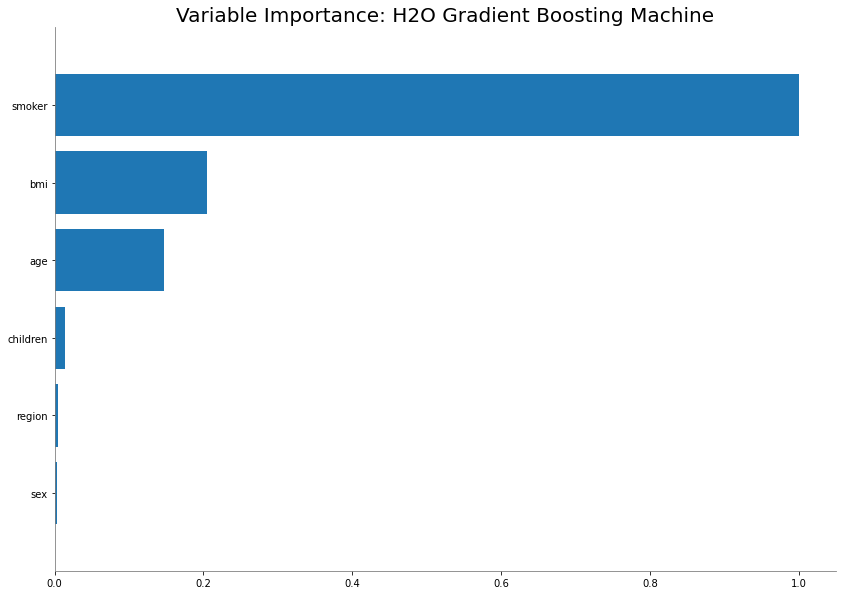

<Figure size 432x288 with 0 Axes>

In [23]:
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

114
glm


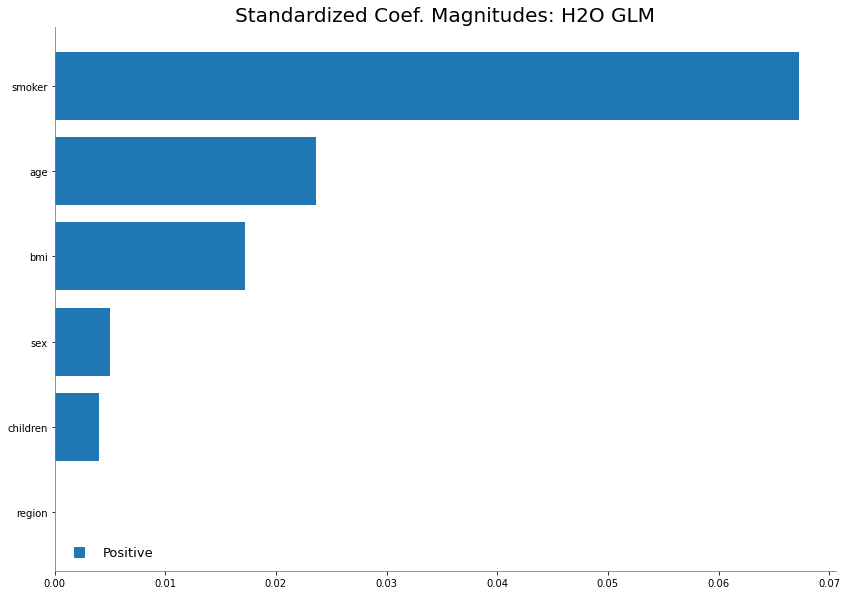

In [24]:
if glm_index is not 0:
  print(glm_index)
  glm_model=h2o.get_model(aml.leaderboard[glm_index,'model_id'])
  print(glm_model.algo) 
  glm_model.std_coef_plot()

In [25]:
print(best_model.rmse(train = True))

3951.4142306923845


In [26]:
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass   
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d

In [27]:
mod_perf=best_model.model_performance(df_test)
stats_test={}
stats_test=model_performance_stats(mod_perf)
stats_test

{'mse': 21808695.909095466,
 'null_degrees_of_freedom': None,
 'null_deviance': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'rmse': 4669.978148674302}

In [28]:
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [29]:
y_pred=h2o.as_list(predictions)
y_pred[0:5]

,predict
0,5605.511680
1,4924.922951
2,4507.273074
3,13863.264523
4,39836.810514


## **Calculating P-value using OLS**

In [30]:
import pandas as pd
# Import the processed data from notebook One
url = "https://github.com/Ritujauni/Data-Science/raw/main/insurance.csv"
df1 = pd.read_csv(url)

In [31]:
#OLS model Library
import statsmodels.formula.api as smf 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [32]:
results = smf.ols('charges ~ age +  sex + bmi + children + smoker + region', data=df1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     668.1
Date:                Mon, 14 Feb 2022   Prob (F-statistic):               0.00
Time:                        04:49:46   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1331   BIC:                         2.715e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.323e+04   1076.023    -12.295      0.000   -1.53e+04   -1.11e+04
age          257.2881     11.886     21.647      0.000     233.971     280.605
sex         -131.1106    332.811     -0.394      0.694    -784.001     521.780
bmi          332.5701     27.722     11.997      0.000     278.186     386.954
children     479.3694    137.644      3.483      0.001     209.346     749.393
smoker      2.382e+04    411.843     57.839      0.000     2.3e+04    2.46e+04
region       353.6400    151.927      2.328      0.020      55.598     651.682
==============================================================================
Omnibus:                      299.003   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              713.975
Skew:                           1.207   Prob(JB):                    9.17e-156
Kurtosis:                       5.642   Cond. No.                         335.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## **Correlation Heatmap**
The correlation coefficient has values between -1 to 1:

1. A value closer to 0 indicates weaker correlation
2. A value closer to 1 indicates stronger positive correlation
3. A value closer to -1 indicates stronger negative correlation

Note : Exact 0 implying no correlation

In [33]:
multi_df = pd.read_csv(url)

In [34]:
# Transforming categorical features to numerical values
multi_df["smoker"] = multi_df["smoker"].replace(["yes","no"], [1,0])
multi_df["sex"] = multi_df["sex"].replace(["male","female"], [1,0])
multi_df1=multi_df.drop('charges',1)
multi_df2=multi_df1.drop('region',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

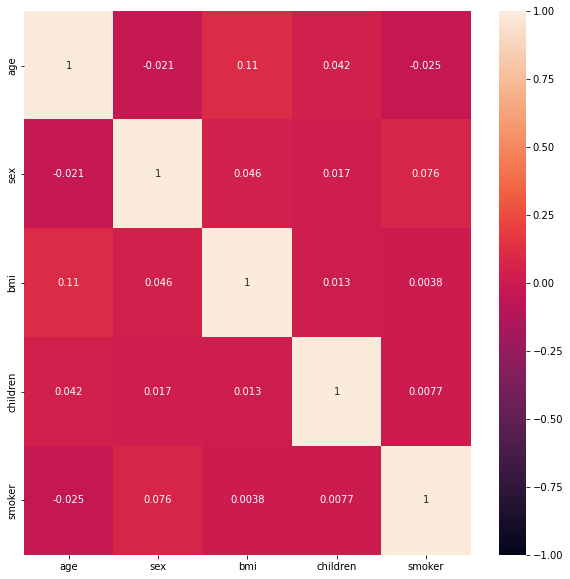

In [36]:
plt.figure(figsize = (10,10))
sns.heatmap(multi_df2.corr(), vmin= -1,vmax=1,annot=True);

## **Residual Analysis Plot**



# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

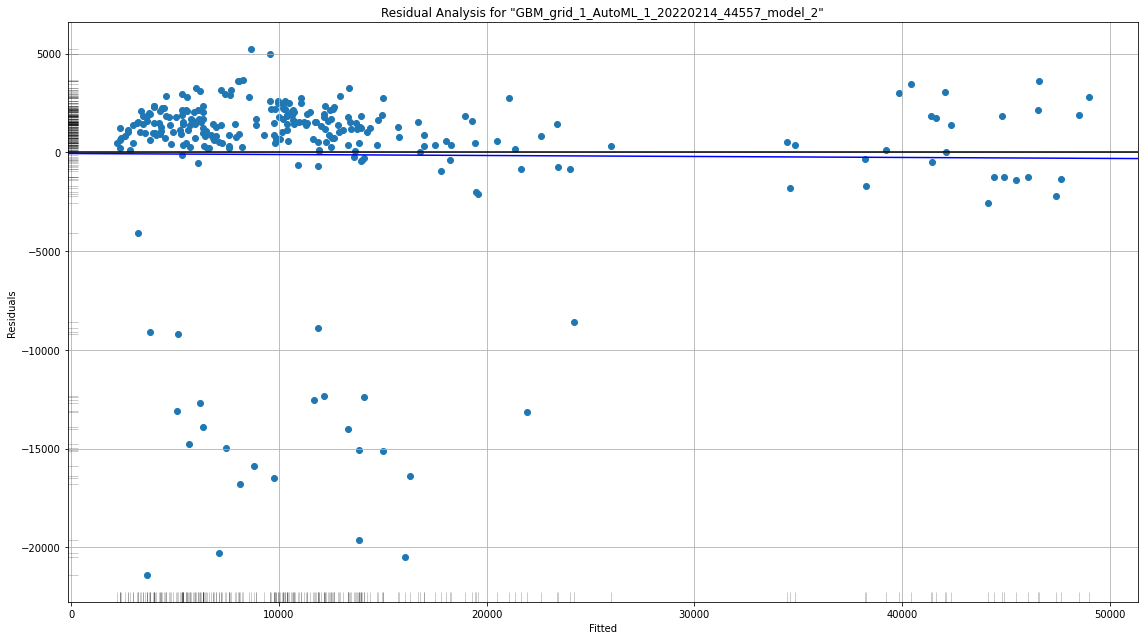

In [37]:
exa = aml.leader.explain(df_test, include_explanations = "residual_analysis")

## **Regularization**

In [38]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

charges_glm = H2OGeneralizedLinearEstimator(family = 'gaussian', lambda_ = 0, compute_p_values = True)


charges_glm_regularization = H2OGeneralizedLinearEstimator(family = 'gaussian', lambda_ = .001, alpha = 0)

In [39]:
df_r= df.drop(['children', 'region','sex'], axis = 1)
X1=df_r.columns
y1='charges'

X1.remove(y1)

In [40]:
pct_rows=0.80
df1_train,df1_test = df.split_frame([pct_rows])

In [41]:
charges_glm_regularization.train(x = X, y= y,training_frame = df1_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1644813940854_1


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,Ridge ( lambda = 0.001 ),6,6,1,py_15_sid_860b




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 37177062.11969134
RMSE: 6097.299576016529
MAE: 4161.405533417274
RMSLE: NaN
R^2: 0.7496139308864522
Mean Residual Deviance: 37177062.11969134
Null degrees of freedom: 1070
Residual degrees of freedom: 1064
Null deviance: 159020961793.73627
Residual deviance: 39816633530.18943
AIC: 21724.184236375808

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,training_rmse,training_deviance,training_mae,training_r2
0,,2022-02-14 04:49:48,0.000 sec,0,159020961874.052979,148478955.998182,,,,
1,,2022-02-14 04:49:48,0.014 sec,1,,,6097.299576,37177062.119691,4161.405533,0.749614



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,smoker,9610.063477,1.000000,0.591924
1,age,3589.272949,0.373491,0.221078
2,bmi,1976.989502,0.205721,0.121771
3,children,577.744080,0.060119,0.035586
4,region,384.355988,0.039995,0.023674
5,sex,96.881668,0.010081,0.005967


## **Hyperparameters**

In [42]:
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV

In [43]:
dfr = pd.read_csv(url)
dfr1=dfr.drop(['children', 'region','sex'],axis=1)

In [44]:
m = dfr1['charges']

n = dfr1.drop(['charges'], axis = 1)

In [45]:
n_train, n_test, m_train, m_test = train_test_split (n, m, random_state = 101, test_size = 0.2)

In [46]:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

param_vals = {'max_depth': [200,500], 'n_estimators': [100,200]}

random_rf = RandomizedSearchCV(estimator=model, param_distributions=param_vals,

n_iter=10, scoring='accuracy', refit=True, n_jobs=-1)

In [47]:
random_rf.fit(n_train, m_train)

preds = random_rf.best_estimator_.predict(n_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  category=UserWarning,


In [48]:
random_rf.best_params_

{'max_depth': 200, 'n_estimators': 100}

## **Questions related to model**

**Q1.Is the relationship significant?**

To prove significance of predictor variables with target variable, P value is used.  With a value of less than 0.05, the null hypothesis can be rejected. To summarize, if p value is less than 0.05, we can say that the predictor variable has significant effect on the target variable. To demonstrate this, ols regression is used through which, p value is calculated which depicts that Sex predictor variable has p values greater than 0.05 while all the other predictors have p values close to zero. Hence, it can be concluded that all the predictor variables, except for sex will affect the target variable.


**Q2. Are any model assumptions violated?**

The correlation heatmap asserts that there is low correlation between the predictor variables. Also, the residual analysis plot, plots the fitted values vs residuals on a test dataset which shows homoscedasticity. Additionally, from the Ols regression, the value of 2.08 for Durban - Watson score explains that there is no autocorrelation.


**Q3. Is there any multicollinearity?**

From the correlation matrix, it can be seen that all the independent variables have low collinearity as all the values are close to zero. 

**Q4. In the multivariate models are predictor variables independent of all the other predictor variables?**

The correlation matrix asserts that none of the independent variables are correlated with each other. 

**Q5. In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model**

From the OLS regression, the p values of zero for the predictors age, bmi, smoker,children, region states that  the variables are significant. However, the predictor sex has p value which infers they are insignificant.

**Q6.Does the model make sense?**

The leaderboard depicts that the metrics of the GBM model like mse, rmse and mean residual deviance is better than the other models from
the leaderboard. Hence, the model makes sense.

**Q7. Does regularization help?**

The values of alpha(0.02 to 0.8) and lambda(0.001 to 1) were tuned through regularization. However, this degraded the performance of the model such as mse, rmse and deviance instead of improving it. Hence, regularization did not help.

**Q8. Which independent variables are significant?**

The p value less than 0.05 illustrates that the variable is not significant. From the OLS regression, the p values are close to zero for all the variables except for the independent variable sex. Hence, the variables _ are significant.

**Q9. Which hyperparameters are important?**

I used RandomizedSearchCV, which contains a few key hyperparameters like max depth and n_estimators.

**max depth:** This specifies the tree's maximum depth. Deeper trees, on the whole, give superior accuracy, but they can also lead to overfitting. As a result, large depth is often reserved for bigger datasets.

**n estimators:** The defines number of trees that needs to be calculated. The more the number of trees, the better will be  the performance, but the code becomes slower.



# **Conclusion**

With the exception of the predictor variable sex, all of the predictors had a substantial influence on insurance charges in the Medical Cost Personal Dataset, as shown by the methods used above. GLM, the best model chosen, outperformed the other models on the leaderboard, scoring higher on metrics like MSE, RMSE, and MAE. Furthermore, there is no autocorrelation and the correlation between the predictor variables is low. However, after modifying the hyperparameters, the MSE and RSME values did not improve, indicating that more research is needed to find the ideal hyperparameters.

# **References**

* Dataset (https://www.kaggle.com/mirichoi0218/insurance)

* Github(https://github.com/nikbearbrown/AI_Research_Group/blob/main/Kaggle_Datasets/AutoML/VAI_Churn_H2O_automl.ipynb)

* H2O offical documentation (https://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html)

* Visualization (https://seaborn.pydata.org/generated/seaborn.heatmap.html)

* OLS (https://towardsdatascience.com/understanding-the-ols-method-for-simple-linear-regression-e0a4e8f692cc)

* Regularization (https://www.nbshare.io/notebook/391169912/Lasso-and-Ridge-Linear-Regression-Regularization/)

* Hyperparameter tuning (https://towardsdatascience.com/hyperparameter-tuning-in-python-21a76794a1f7)



MIT License

Copyright (c) 2022 Rituja Lolam

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.